# Measure systematic uncertainties in resolution with Kr data

<i>
This notebook takes a kDST file and a correction file,
applies all corrections (including time) and measures
the variation of the resolution when the corrections
are off by a certain value
</i>

### Notebook configuration

In [1]:
run_number          = 4841
correction_filename = f"$IC_DATA/XYmaps/corrections_run{run_number}.h5"
dst_filename        = f"$IC_DATA/Kr/dst_{run_number}_filtered.root.h5"
XY_pitch            =  5.0
Erange              = 33.5, 49.5

XYnbins =  50
Rmax    = 220
Zmax    = 600
Enbins  = 200

# Plotting style
default_cmap        = "jet"
figure_size         = 16, 12
font_size           = 20
global_linewidth    = 4
subfit_linewidth    = 4
global_linecolor    = "r"
subfit_linecolor    = "m g b y".split()
subfit_linecolor    = "b m slategrey c b y".split()

### Imports

In [2]:
import os
import time
import collections
print("Running on ", time.asctime())

import numpy             as np
import matplotlib.pyplot as plt
import scipy.optimize    as opt

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.corrections    as corrf
import invisible_cities.reco.dst_functions  as dstf

from invisible_cities.core .stat_functions import poisson_sigma
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import resolution
from invisible_cities.icaro. hst_functions import gausstext
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import labels
from invisible_cities.icaro. hst_functions import measurement_string

Running on  Thu Sep  6 18:23:50 2018


### Initialization

In [3]:
%matplotlib inline

plt.rcParams["figure.figsize"         ] = figure_size
plt.rcParams[  "font.size"            ] =   font_size
plt.rcParams["figure.max_open_warning"] =        1000

In [4]:
Ebins = np.linspace(*Erange, Enbins + 1)

dst_filename        = os.path.expandvars(       dst_filename)
correction_filename = os.path.expandvars(correction_filename)

### Read data

In [5]:
dst = dstf.load_dst(dst_filename, "DST", "Events")
dst = dst[dst.R < Rmax]
dst = dst[dst.Z < Zmax]
print("Number of S2s   :", len(dst))
print("Number of events:", len(np.unique(dst.event)))
dst.head()

Number of S2s   : 778017
Number of events: 776458


,index,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,6,8,1.510471e+09,0,1,200.0,3.353130,16.994588,823725.0,14.7000,...,1002500.0,41,178.775,178.775,-180.623891,-61.067526,190.667860,-2.815565,18.316797,15.352102
1,12,21,1.510471e+09,0,1,125.0,1.271123,5.763685,883425.0,6.3500,...,1002500.0,36,119.075,119.075,-168.270263,23.257575,169.869939,3.004247,11.466820,13.968665
2,14,27,1.510471e+09,0,1,150.0,1.976865,8.930014,859950.0,6.8375,...,1003500.0,36,143.550,143.550,5.004905,-31.789076,32.180653,-1.414637,22.182517,29.385406
3,17,29,1.510471e+09,0,1,275.0,3.722116,22.847745,613025.0,10.3750,...,1004500.0,35,391.475,391.475,-30.362521,-136.884955,140.211888,-1.789073,14.704709,36.006950
4,18,32,1.510471e+09,0,1,150.0,2.090557,10.226970,449425.0,11.4625,...,1003500.0,28,554.075,554.075,117.304421,41.295697,124.361014,0.338490,23.385198,15.873189


In [6]:
LT_correction0  = dstf.load_lifetime_xy_corrections(correction_filename,
                                                    group = "XYcorrections",
                                                    node  = "Lifetime")

GEO_correction0 = dstf.load_xy_corrections(correction_filename,
                                           group         =  "XYcorrections",
                                           node          = f"GeometryE_{XY_pitch:.1f}mm",
                                           norm_strategy =  "const",
                                           norm_opts     = {"value": 41.5})

In [7]:
T   =(dst.time .values -
      dst.time.values.min()) / 60
S2e = dst.S2e.values
X   = dst.X    .values
Y   = dst.Y    .values
Z   = dst.DT   .values
R   = dst.R    .values
E_  = S2e * LT_correction0(Z, X, Y).value * GEO_correction0(X, Y).value

In [8]:
t, e, eu = fitf.profileX(T, E_, 100)
T_correction0 = corrf.Correction((t,), e, eu, norm_strategy="const", norm_opts={"value": 41.5})
E = E_ * T_correction0(T).value

##### Input maps

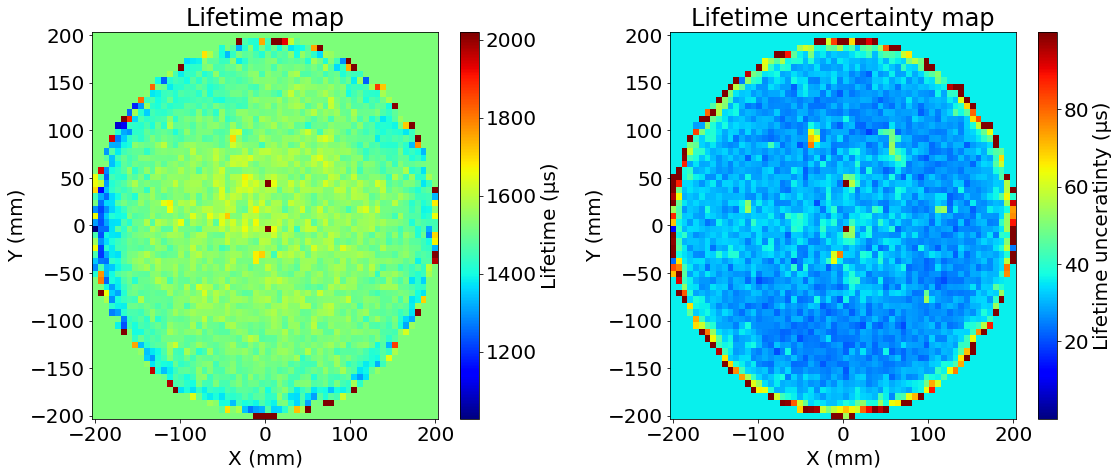

In [9]:
LTmap = dstf.load_dst(correction_filename,
                      group = "XYcorrections",
                      node  = "Lifetime")

x   = np.unique(LTmap.x.values)
y   = np.unique(LTmap.y.values)
LT  = LTmap.factor     .values.reshape(x.size, y.size)
LTu = LTmap.uncertainty.values.reshape(x.size, y.size)

plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
*_, cb = display_matrix(x, y, LT,
                        vmin = np.mean(LT) - 2.5 * np.std(LT),
                        vmax = np.mean(LT) + 2.5 * np.std(LT),
                        cmap = default_cmap,
                        new_figure=False)
cb.set_label("Lifetime (µs)")
labels("X (mm)", "Y (mm)", "Lifetime map")

plt.subplot(1, 2, 2)
*_, cb = display_matrix(x, y, LTu,
                        vmin = 1e-3,
                        vmax = np.mean(LTu) + np.std(LTu),
                        cmap = default_cmap,
                        new_figure=False)

cb.set_label("Lifetime unceratinty (µs)")
labels("X (mm)", "Y (mm)", "Lifetime uncertainty map")

plt.tight_layout()

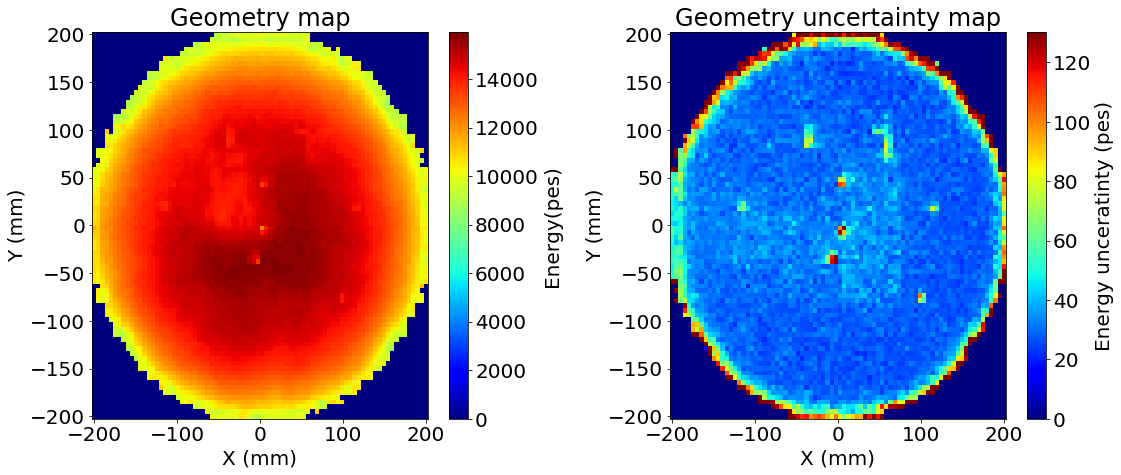

In [10]:
GEOmap = dstf.load_dst(correction_filename,
                       group = "XYcorrections",
                       node  = f"GeometryE_{XY_pitch:.1f}mm")

x  = np.unique(GEOmap.x.values)
y  = np.unique(GEOmap.y.values)
f  = GEOmap.factor     .values.reshape(x.size, y.size)
fu = GEOmap.uncertainty.values.reshape(x.size, y.size)

plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
*_, cb = display_matrix(x, y, f,
                        cmap = default_cmap,
                        new_figure=False)
cb.set_label("Energy(pes)")
labels("X (mm)", "Y (mm)", "Geometry map")

plt.subplot(1, 2, 2)
*_, cb = display_matrix(x, y, fu,
                        vmax = np.mean(fu) + 3 * np.std(fu),
                        cmap = default_cmap,
                        new_figure=False)
cb.set_label("Energy unceratinty (pes)")
labels("X (mm)", "Y (mm)", "Geometry uncertainty map")

plt.tight_layout()

##### Energy resolution

In [11]:
xy_data       = collections.namedtuple(      "xy_data", "x y xu yu"       )
reso_fit_data = collections.namedtuple("reso_fit_data", "xy residuals f R")

def measure_resolution(E, *, bkg=fitf.gauss, n_sigma=2.5, nbins=None, degree=2):
    ebins = Ebins if nbins is None else np.linspace(*Erange, nbins + 1)

    y, x  = np.histogram(E, ebins)
    x     = shift_to_bin_centers(x)
    xu    = np.diff(x)[0] * 0.5
    yu    = poisson_sigma(y)

    fun   = lambda x, *args: fitf.gauss(x, *args[:3]) + bkg(x, *args[3:])
    Npeak = np.size(E) * np.diff(Ebins)[0]
    Epeak = np.average( x            , weights=y)
    Speak = np.average((x - Epeak)**2, weights=y)**0.5

    bkg_seed = (Npeak*2, Epeak, Speak*50) if bkg is fitf.gauss else (1 for i in range(degree + 1))
    sig_seed  = Npeak, Epeak, Speak

    seed = np.array((*sig_seed, *bkg_seed))
    seed = np.random.normal(seed, np.abs(0.01*seed))
    fit_range = (Epeak - n_sigma * Speak,
                 Epeak + n_sigma * Speak)
    f    = fitf.fit(fun, x, y, seed,
                    fit_range = fit_range,
                    sigma     = yu,
                    maxfev    = 10000)

    assert not np.any(np.isclose(f.values, seed)), f.values

    R   = resolution(f.values, f.errors, 41.5)
    sel = coref.in_range(x, *fit_range)
    ry  = (f.fn(x) - y) / yu
    return reso_fit_data(xy_data(x, y, xu, yu),
                         xy_data(x[sel], ry[sel], xu, yu[sel]),
                         f, R)

def plot(data, signal=fitf.gauss, bkg=fitf.gauss, title=""):
    print("Resolution at 41.5 keV:", measurement_string(*data.R[0]))
    print("Resolution at 2458 keV:", measurement_string(*data.R[1]))
    print("Chi2                  :", data.f.chi2)

    x = data.xy.x
    plt.errorbar    (x, data.xy.y, data.xy.yu, data.xy.xu, "p", c="k")
    plt.plot        (x, data.f.fn   (x)               , lw=global_linewidth, color=global_linecolor   )
    plt.plot        (x, signal(x, *data.f.values[ :3]), lw=subfit_linewidth, color=subfit_linecolor[0])
    plt.fill_between(x, signal(x, *data.f.values[ :3]),    0,     alpha=0.3, color=subfit_linecolor[0])
    plt.plot        (x, bkg   (x, *data.f.values[3: ]), lw=subfit_linewidth, color=subfit_linecolor[1])
    plt.fill_between(x, bkg   (x, *data.f.values[3: ]),    0,     alpha=0.3, color=subfit_linecolor[1])
    plt.text(plt.xlim()[0] + np.diff(plt.xlim()) * 0.03,
             max(data.xy.y) / 1.5,
             gausstext(data.f.values, data.f.errors, 41.5))
    plt.ylim(0)
    labels("E (keV)", "Entries", title)
    
def relative_to(x, fraction=0.5):
    return x[0] + np.diff(x) * fraction

## Reference value

Resolution at 41.5 keV: 4.862 +- 0.012
Resolution at 2458 keV: 0.6318 +- 0.0016
Chi2                  : 10.6877036565


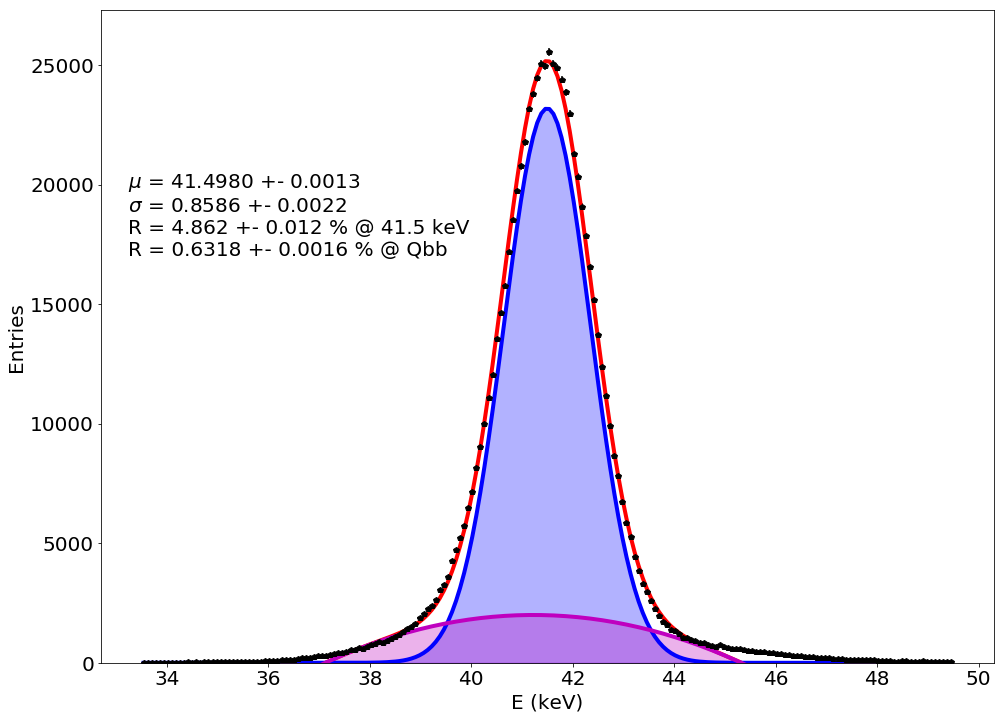

In [12]:
bkg  = fitf.polynom
data = measure_resolution(E, bkg=bkg)
plot(data, bkg=bkg)
true_ylim = plt.ylim()

## Lifetime systematics

In [14]:
nsigmas_lt = 20
n_it       = 20
bkg        = fitf.polynom

sigmas_lt = np.linspace(-5, 5, nsigmas_lt)
E0        = S2e * GEO_correction0(X, Y).value * T_correction0(T).value

LTdst = dstf.load_dst(correction_filename,
                      group = "XYcorrections",
                      node  = "Lifetime")
Xs    = np.unique(LTdst.x.values)
Ys    = np.unique(LTdst.y.values)
LTs   = LTdst.factor     .values.reshape(Xs.size, Ys.size)
LTus  = LTdst.uncertainty.values.reshape(Xs.size, Ys.size)

R_lt  = np.zeros(nsigmas_lt)
Ru_lt = np.zeros(nsigmas_lt)

for i, nsig in enumerate(sigmas_lt):
    r = np.full(n_it, np.nan)
    u = np.full(n_it, np.nan)
    for j in range(n_it):
        sign = np.random.choice([-1, 1], size=LTs.shape)
        lt = corrf.Correction((Xs, Ys), LTs + nsig * LTus * sign, LTus)
        LT_correction = lambda z, x, y: corrf.LifetimeCorrection(*lt(x, y))(z)
        e = E0 * LT_correction(Z, X, Y).value
        try:
            data = measure_resolution(e, bkg=bkg)
            r[j], u[j] = data.R[0]
        except AssertionError:
            pass
    w  = u**-2
    ok = ~(np.isnan(r) | np.isnan(u))
    
    R_lt [i] = np.average( r[ok]              , weights=w[ok])
    Ru_lt[i] = np.average((r[ok] - R_lt[i])**2, weights=w[ok])**0.5

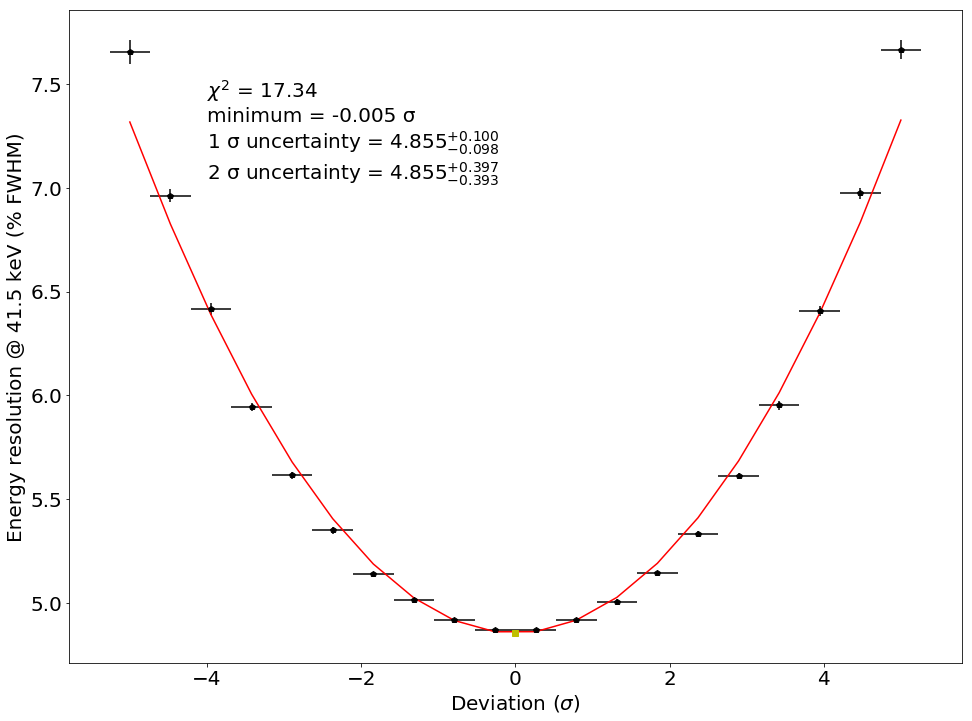

In [15]:
seed = np.ones(3)
f    = fitf.fit(fitf.polynom, sigmas_lt, R_lt, seed, sigma=Ru_lt)

min_data = opt.minimize(f.fn, 0)
min_x    = min_data.x[0]
min_y    = min_data.fun
reso_0   = f.fn( 0)
reso_m1  = f.fn(-1)
reso_p1  = f.fn(+1)
reso_m2  = f.fn(-2)
reso_p2  = f.fn(+2)
delta_m1 = reso_m1 - reso_0
delta_p1 = reso_p1 - reso_0
delta_m2 = reso_m2 - reso_0
delta_p2 = reso_p2 - reso_0

text = f"""
$\chi^2$ = {f.chi2:.2f}
minimum = {min_x:.3f} σ
1 σ uncertainty = ${reso_0:.3f}_{{-{delta_m1:.3f}}}^{{+{delta_p1:.3f}}}$
2 σ uncertainty = ${reso_0:.3f}_{{-{delta_m2:.3f}}}^{{+{delta_p2:.3f}}}$
"""

plt.errorbar(sigmas_lt, R_lt, Ru_lt, np.diff(sigmas_lt)[0]/2, "pk")
plt.plot    (sigmas_lt, f.fn(sigmas_lt), "r-")
plt.plot    (min_x, min_y, "sy")
plt.text    (-4, relative_to(plt.ylim(), 0.7), text)

labels("Deviation ($\sigma$)", "Energy resolution @ 41.5 keV (% FWHM)")

with open("/Users/Gonzalo/github/tese/dat/lt_sys_4841_full.dat", "w") as file:
    file.write("deviation deviationu eres eresu\n")
    su = np.diff(sigmas_lt)[0]/2
    for s, r, ru in zip(sigmas_lt, R_lt, Ru_lt):
        file.write(f"{s} {su} {r} {ru}\n")

## Geometry uncertainties

In [16]:
nsigmas_geo = 15
n_it        = 20
bkg         = fitf.polynom

sigmas_geo = np.linspace(-5, 5, nsigmas_geo) 
E0         = S2e * LT_correction0(Z, X, Y).value * T_correction0(T).value

GEOdst = dstf.load_dst(correction_filename,
                       group = "XYcorrections",
                       node  = f"GeometryE_{XY_pitch:.1f}mm")
Xs     = np.unique(GEOdst.x.values)
Ys     = np.unique(GEOdst.y.values)
Fs     = GEOdst.factor     .values.reshape(Xs.size, Ys.size)
Fus    = GEOdst.uncertainty.values.reshape(Xs.size, Ys.size)

R_geo  = np.zeros (nsigmas_geo)
Ru_geo = np.zeros (nsigmas_geo)

for i, nsig in enumerate(sigmas_geo):
    r = np.full(n_it, np.nan)
    u = np.full(n_it, np.nan)
    for j in range(n_it):
        sign = np.random.choice([-1, 1], size=Fs.shape)
        GEO_correction = corrf.Correction((Xs, Ys), Fs + nsig * Fus * sign, Fus,
                                          norm_strategy="const", norm_opts={"value": 41.5})
        e = E0 * GEO_correction(X, Y).value
        try:
            data = measure_resolution(e, bkg=bkg)
            r[j], u[j] = data.R[0]
        except AssertionError:
            pass
    w  = u**-2
    ok = ~(np.isnan(r) | np.isnan(u))
    
    R_geo [i] = np.average( r[ok]               , weights=w[ok])
    Ru_geo[i] = np.average((r[ok] - R_geo[i])**2, weights=w[ok])**0.5

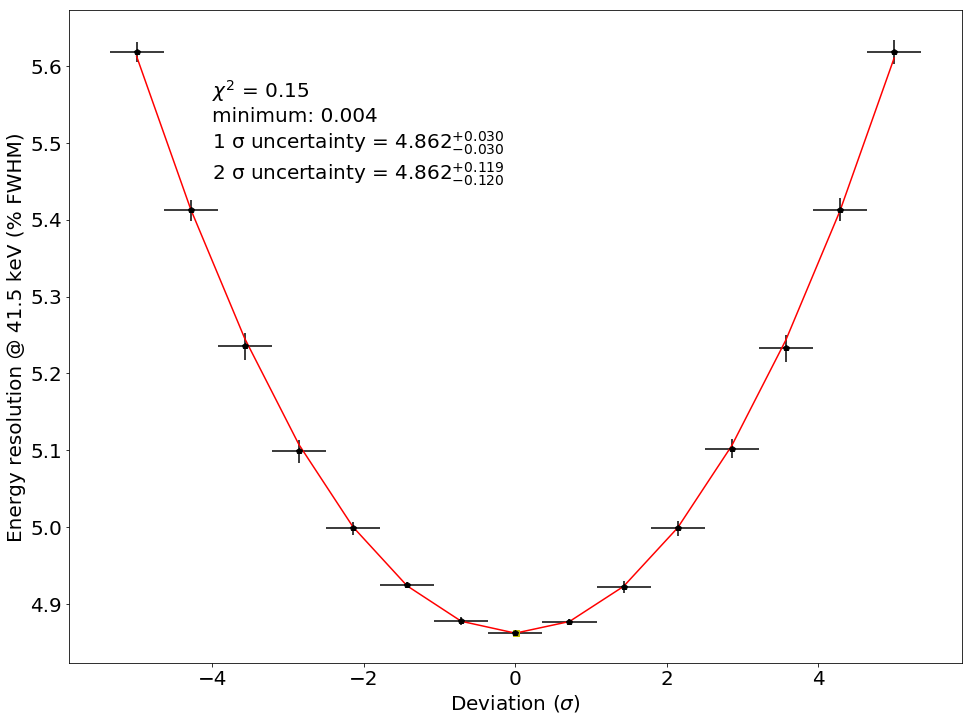

In [18]:
seed = np.ones(3)
f    = fitf.fit(fitf.polynom, sigmas_geo[Ru_geo>0], R_geo[Ru_geo>0], seed, sigma=Ru_geo[Ru_geo>0])

min_data = opt.minimize(f.fn, 0)
min_x    = min_data.x[0]
min_y    = min_data.fun
reso_0   = f.fn( 0)
reso_m1  = f.fn(-1)
reso_p1  = f.fn(+1)
reso_m2  = f.fn(-2)
reso_p2  = f.fn(+2)
delta_m1 = reso_m1 - reso_0
delta_p1 = reso_p1 - reso_0
delta_m2 = reso_m2 - reso_0
delta_p2 = reso_p2 - reso_0

text = f"""
$\chi^2$ = {f.chi2:.2f}
minimum: {min_x:.3f}
1 σ uncertainty = ${reso_0:.3f}_{{-{delta_m1:.3f}}}^{{+{delta_p1:.3f}}}$
2 σ uncertainty = ${reso_0:.3f}_{{-{delta_m2:.3f}}}^{{+{delta_p2:.3f}}}$
"""

plt.errorbar(sigmas_geo, R_geo, Ru_geo, np.diff(sigmas_geo)[0]/2, "pk")
plt.plot    (sigmas_geo, f.fn(sigmas_geo), "r-")
plt.plot    (min_x, min_y, "sy")
plt.text    (-4, relative_to(plt.ylim(), 0.7), text)

labels("Deviation ($\sigma$)", "Energy resolution @ 41.5 keV (% FWHM)")

with open("/Users/Gonzalo/github/tese/dat/geo_sys_4841_full.dat", "w") as file:
    file.write("deviation deviationu eres eresu\n")
    su = np.diff(sigmas_lt)[0]/2
    for s, r, ru in zip(sigmas_lt, R_lt, Ru_lt):
        file.write(f"{s} {su} {r} {ru}\n")

## Binning systematics

In [49]:
bkg      = fitf.polynom
nbins    = np.arange(50, 1000, 80)
R_nbins  = np.zeros(nbins.size)
Ru_nbins = np.zeros(nbins.size)
for i, n in enumerate(nbins):
    data = measure_resolution(E, bkg=bkg, nbins=n)
    R_nbins[i], Ru_nbins[i] = data.R[0]

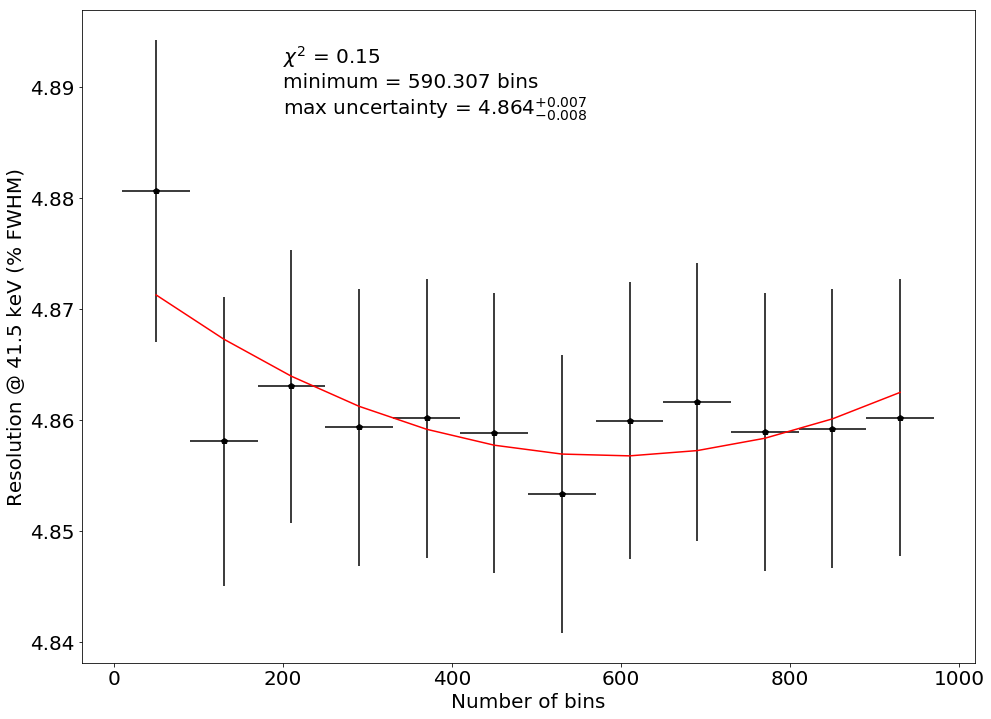

In [50]:
### seed = np.ones(3)
f = fitf.fit(fitf.polynom, nbins, R_nbins, seed, sigma=Ru_nbins)

min_data = opt.minimize(f.fn, 0)
max_data = opt.minimize(lambda x: -f.fn(x), 0, bounds=((nbins[0], nbins[-1]),))
min_x    = min_data.x[0]
max_x    = max_data.x[0]
min_y    = f.fn(min_x)
max_y    = f.fn(max_x)
reso_0   = f.fn( 200 )
delta_m  = abs(min_y - reso_0)
delta_p  = abs(max_y - reso_0)

text = f"""
$\chi^2$ = {f.chi2:.2f}
minimum = {min_x:.3f} bins
max uncertainty = ${reso_0:.3f}_{{-{delta_m:.3f}}}^{{+{delta_p:.3f}}}$
"""

plt.errorbar(nbins, R_nbins, Ru_nbins, np.diff(nbins)[0] / 2, "pk")
plt.plot(nbins, f.fn(nbins), "r-")
plt.text(200, relative_to(plt.ylim(), 0.8), text)

labels("Number of bins", "Resolution @ 41.5 keV (% FWHM)")

with open("/Users/Gonzalo/github/tese/dat/bin_sys_4841_full.dat", "w") as file:
    file.write("nbin nbinu eres eresu\n")
    nu = np.diff(nbins)[0] / 2
    for n, r, ru in zip(nbins, R_nbins, Ru_nbins):
        file.write(f"{n} {nu} {r} {ru}\n")

### Fit range systematics

Resolution at 41.5 keV: 4.862 +- 0.012
Resolution at 2458 keV: 0.6318 +- 0.0016
Chi2                  : 10.6877036574
Resolution at 41.5 keV: 4.912 +- 0.011
Resolution at 2458 keV: 0.6383 +- 0.0014
Chi2                  : 12.4610199137
Resolution at 41.5 keV: 4.9453 +- 0.0093
Resolution at 2458 keV: 0.6426 +- 0.0012
Chi2                  : 14.3695924564
Resolution at 41.5 keV: 4.9705 +- 0.0085
Resolution at 2458 keV: 0.6459 +- 0.0011
Chi2                  : 15.7151690817
Resolution at 41.5 keV: 5.0001 +- 0.0078
Resolution at 2458 keV: 0.6497 +- 0.0010
Chi2                  : 17.0905113898
Resolution at 41.5 keV: 5.0337 +- 0.0073
Resolution at 2458 keV: 0.65406 +- 0.00095
Chi2                  : 18.2719324988
Resolution at 41.5 keV: 5.0591 +- 0.0071
Resolution at 2458 keV: 0.65736 +- 0.00092
Chi2                  : 18.986450485
Resolution at 41.5 keV: 5.0931 +- 0.0067
Resolution at 2458 keV: 0.66178 +- 0.00088
Chi2                  : 20.3333628041
Resolution at 41.5 keV: 5.1236 +- 0.006

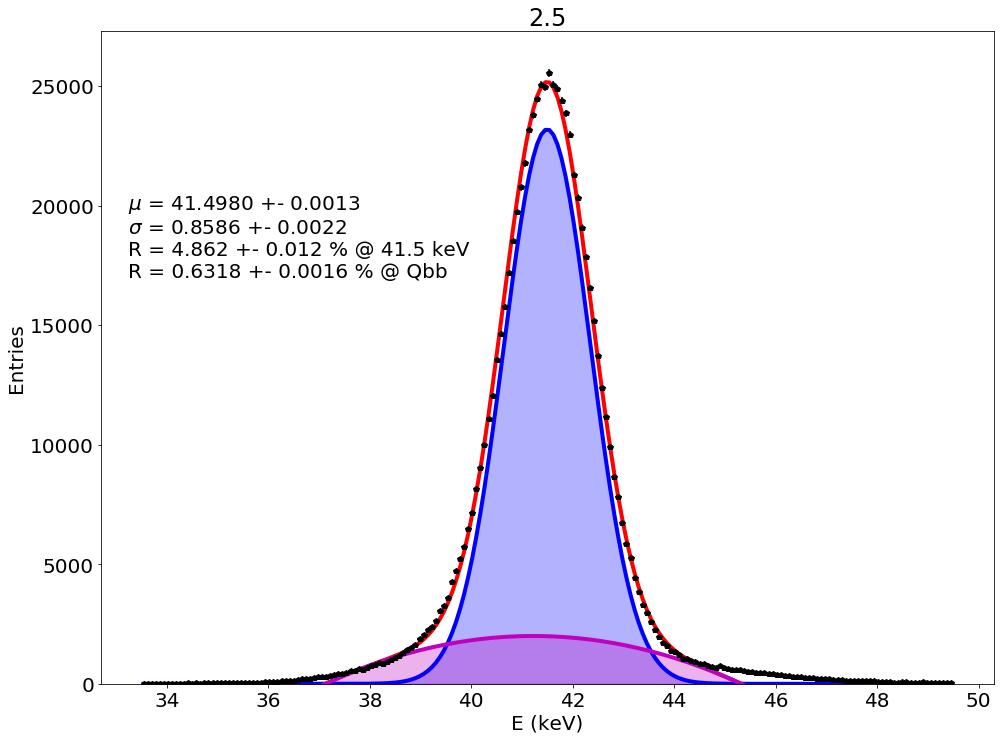

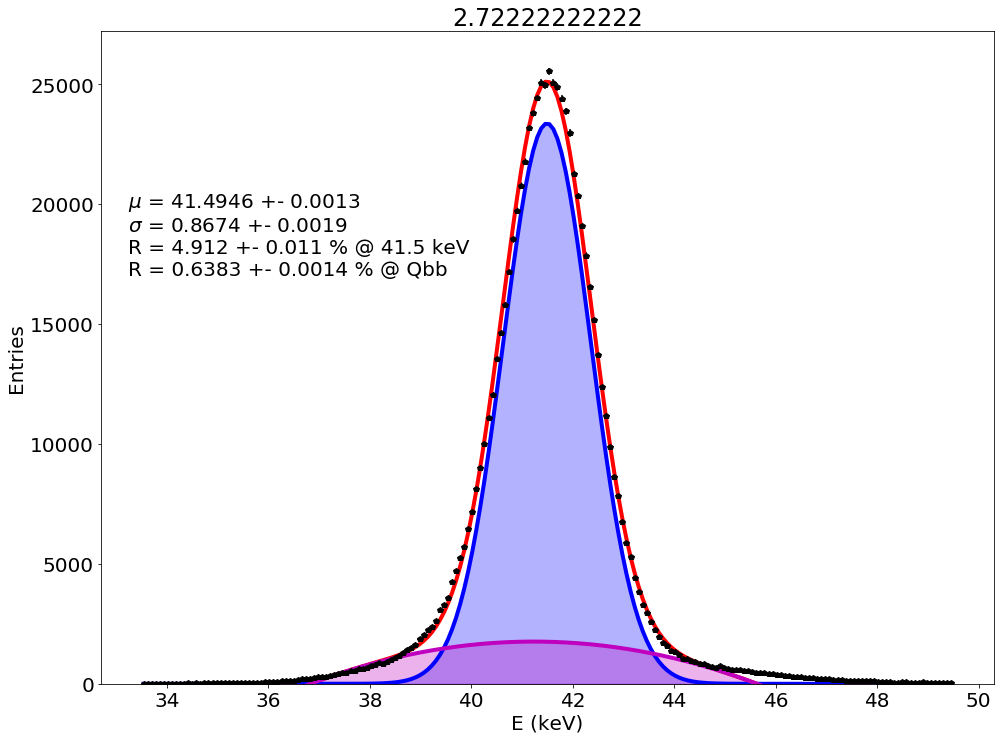

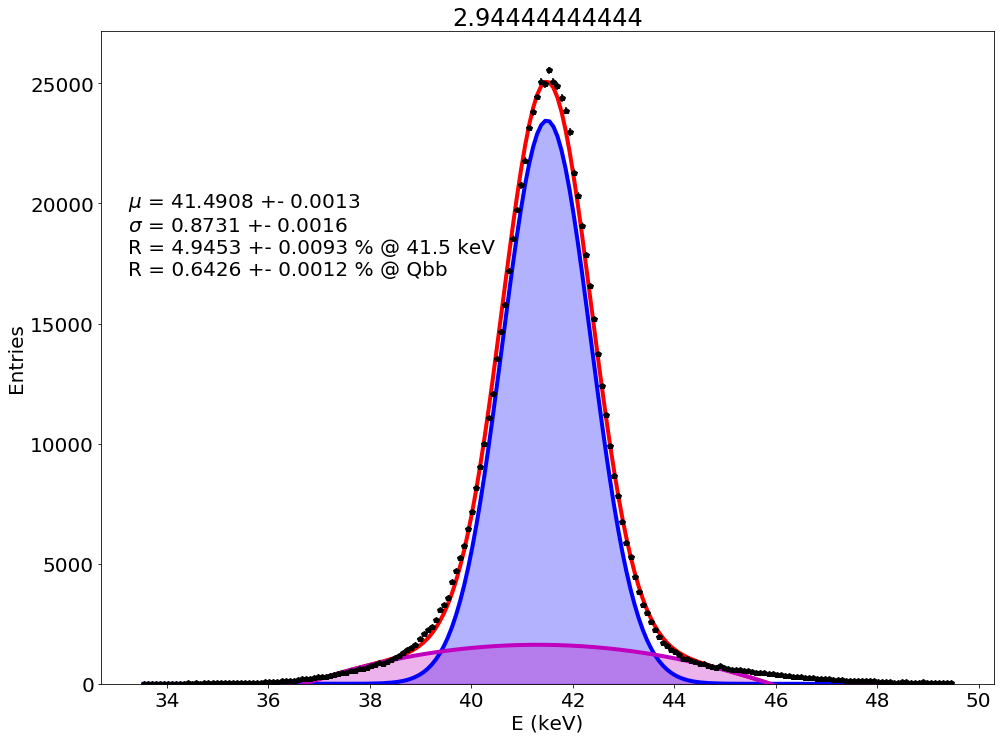

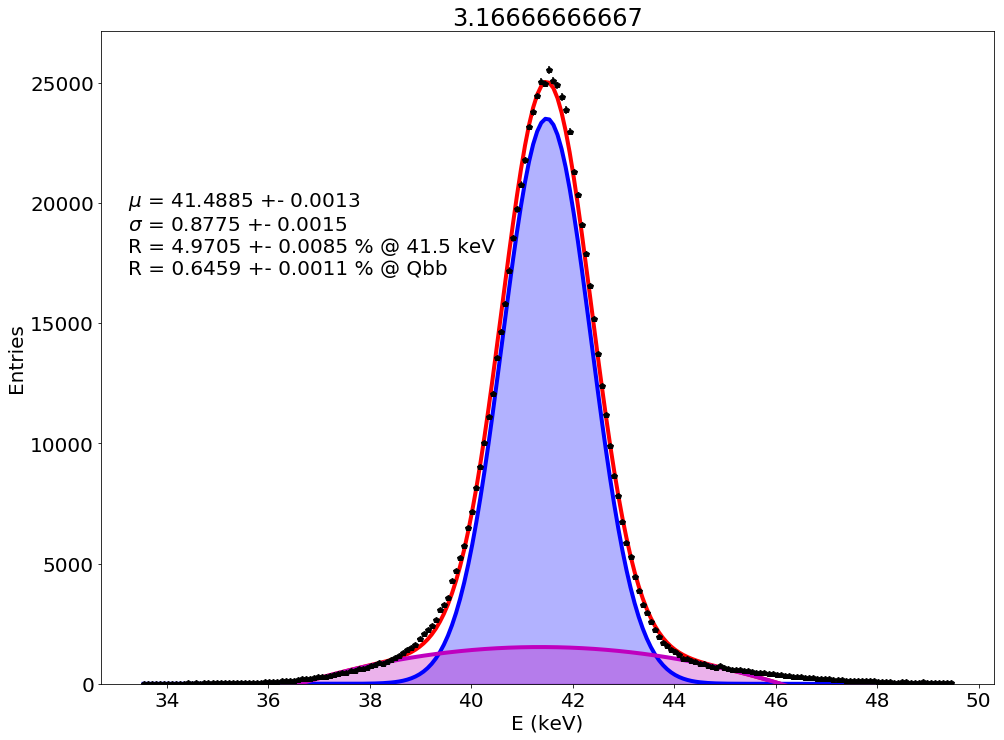

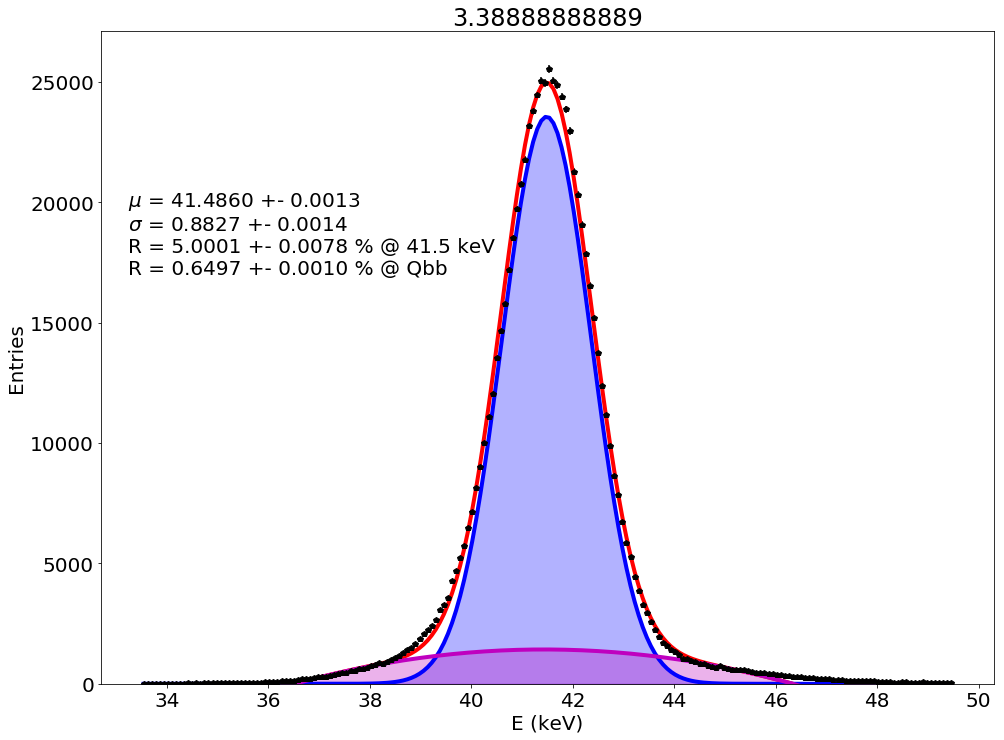

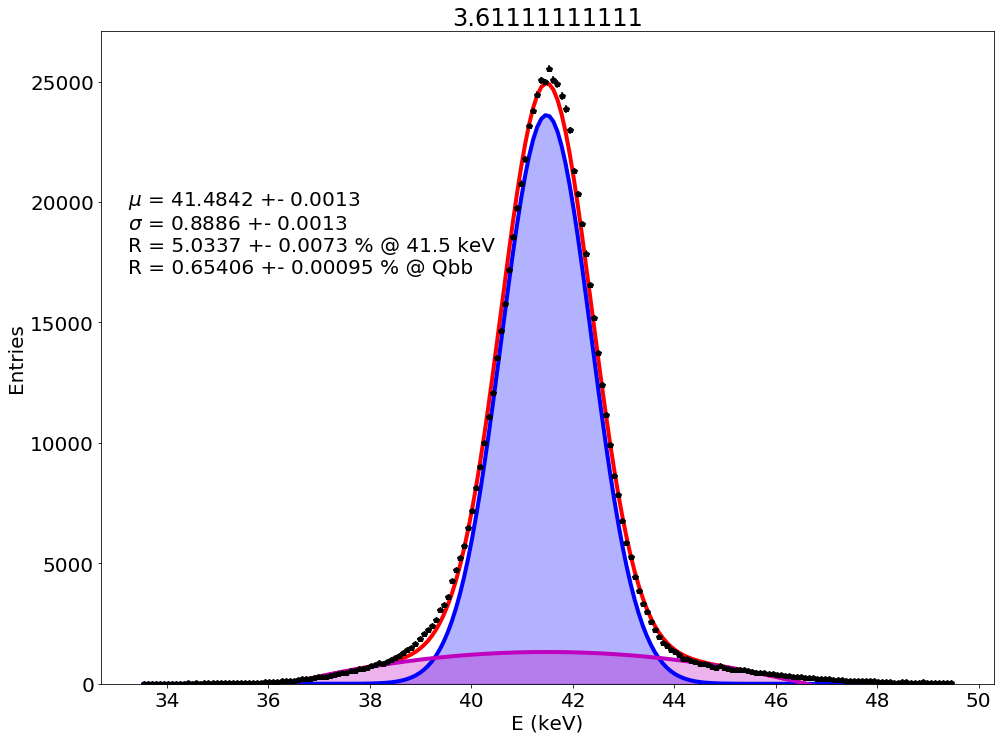

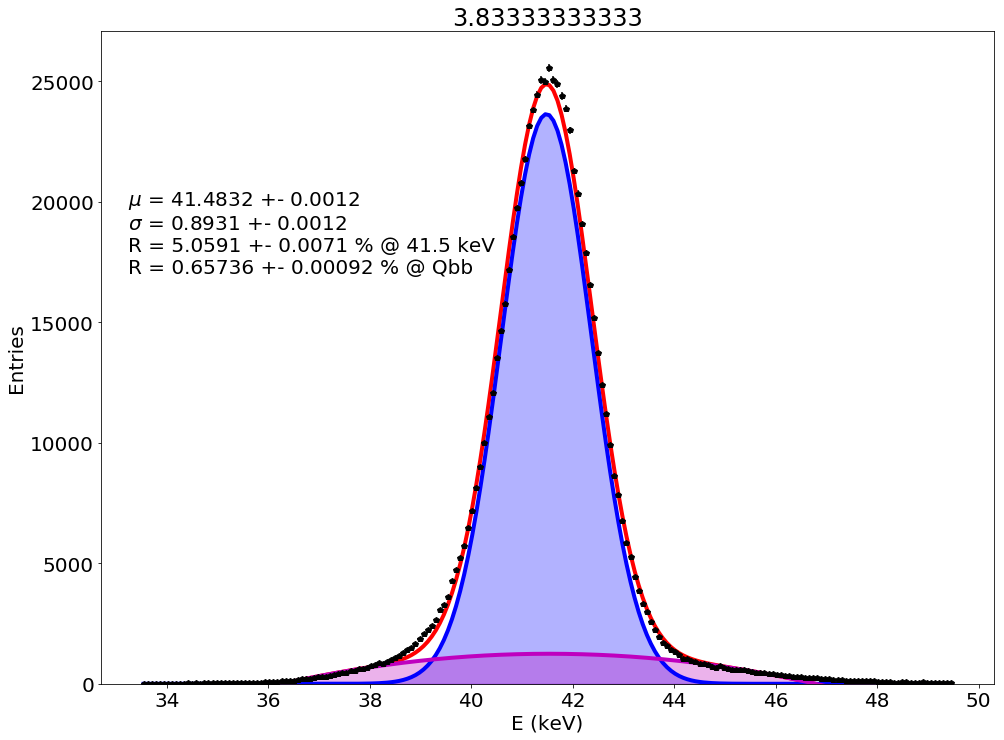

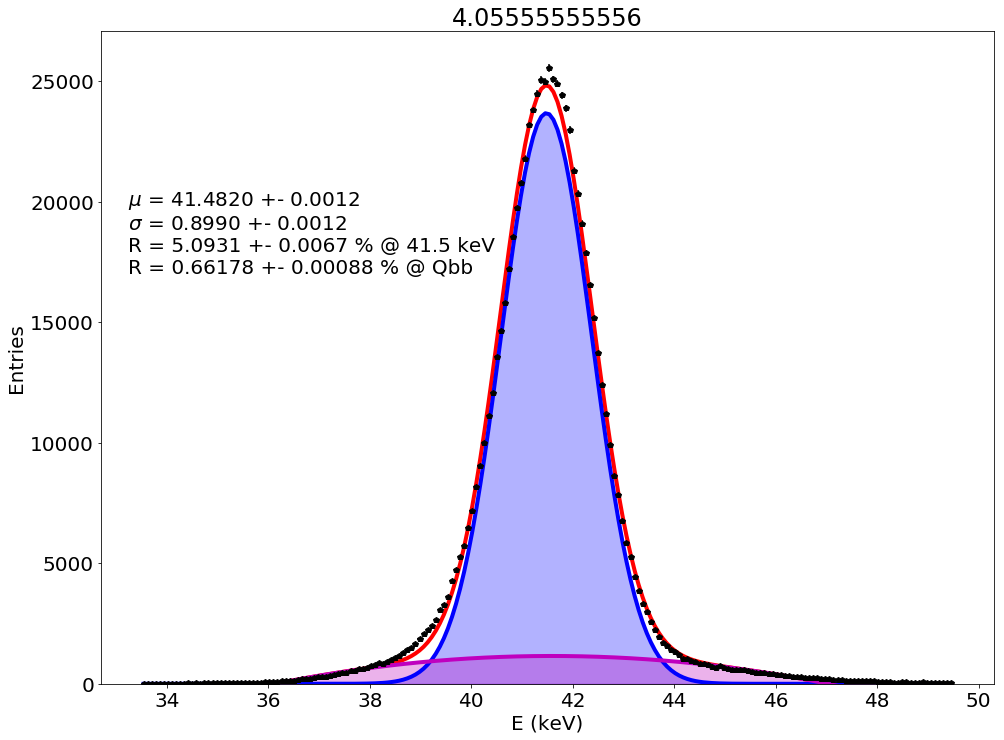

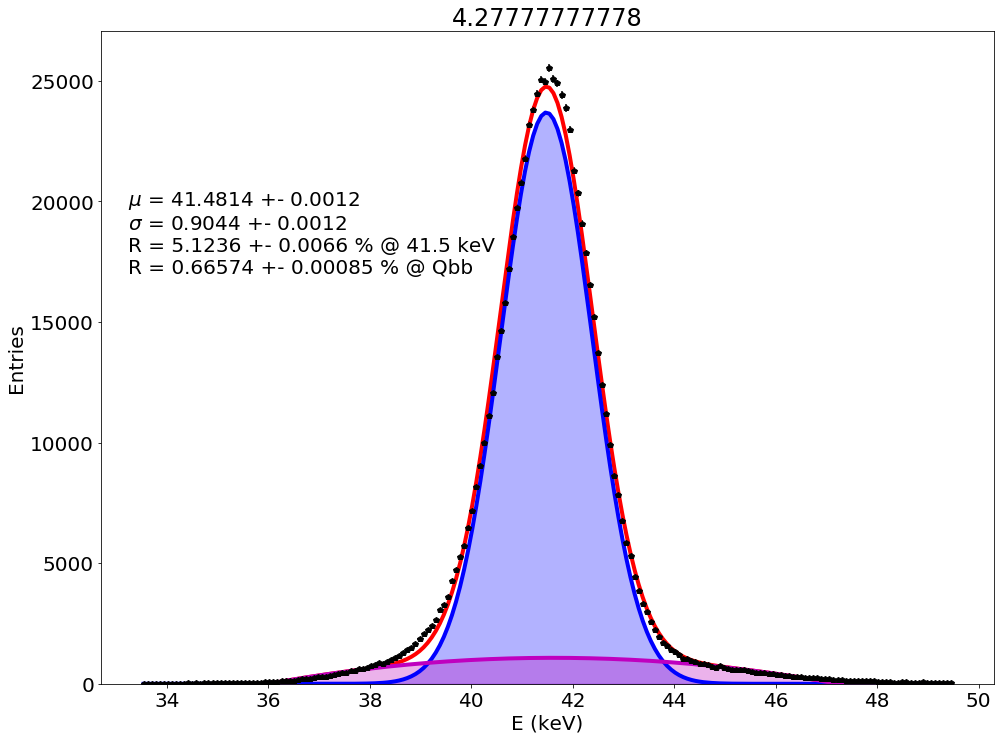

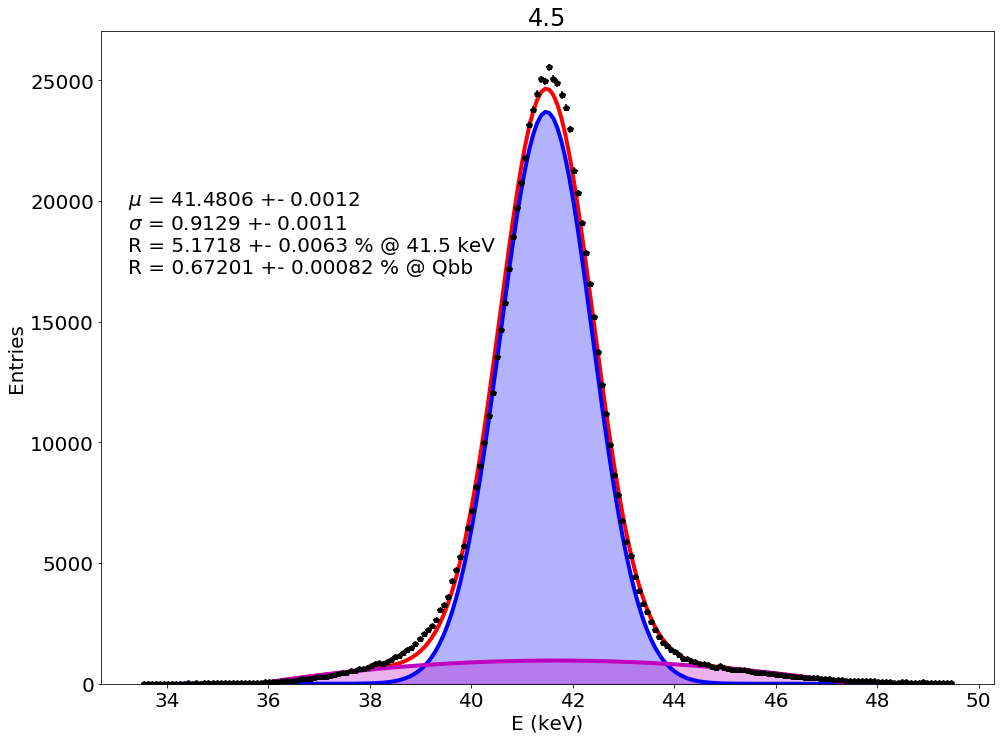

In [21]:
bkg      = fitf.polynom
nsigmas  = np.linspace(2.5, 4.5, 10)
R_range  = np.zeros(nsigmas.size)
Ru_range = np.zeros(nsigmas.size)
chi2_range = np.zeros(nsigmas.size)
for i, n in enumerate(nsigmas):
    data = measure_resolution(E, bkg=bkg, n_sigma=n)
    plt.figure()
    plot(data, bkg=bkg)
    R_range[i], Ru_range[i] = data.R[0]
    chi2_range[i] = data.f.chi2
    plt.title(str(n))

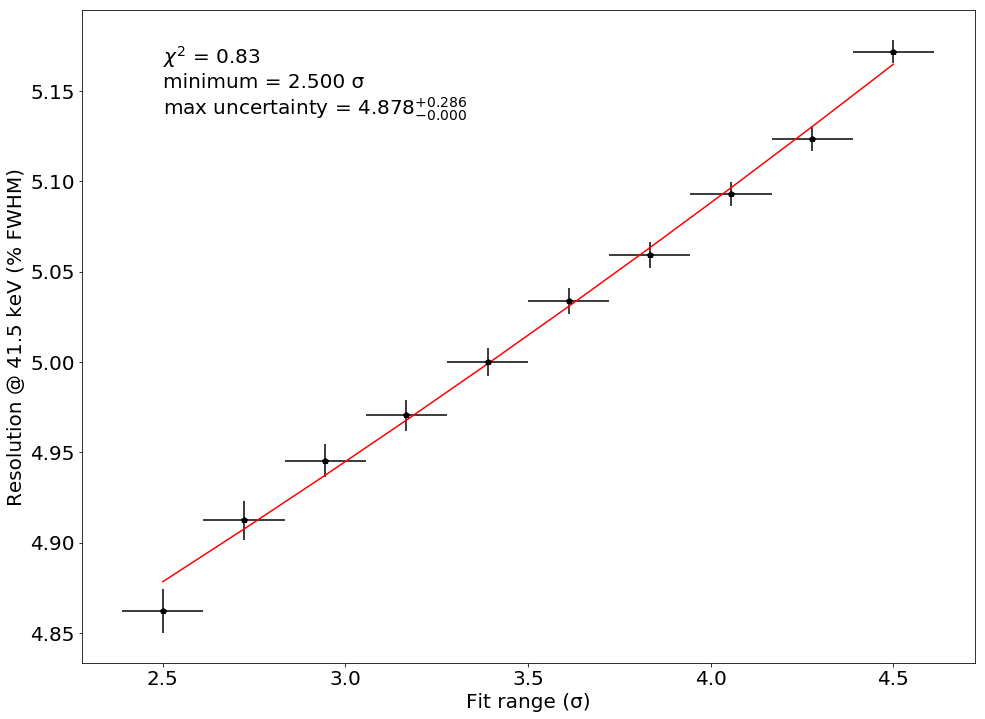

In [23]:
seed = np.ones(3)
f = fitf.fit(fitf.polynom, nsigmas, R_range, seed, sigma=Ru_range)

min_data = opt.minimize(           f.fn   , 0, bounds=((nsigmas[0], nsigmas[-1]),))
max_data = opt.minimize(lambda x: -f.fn(x), 0, bounds=((nsigmas[0], nsigmas[-1]),))
min_x    = min_data.x[0]
max_x    = max_data.x[0]
min_y    = f.fn(min_x)
max_y    = f.fn(max_x)
reso_0   = f.fn( 2.5 )
delta_m  = abs(min_y - reso_0)
delta_p  = abs(max_y - reso_0)

text = f"""
$\chi^2$ = {f.chi2:.2f}
minimum = {min_x:.3f} σ
max uncertainty = ${reso_0:.3f}_{{-{delta_m:.3f}}}^{{+{delta_p:.3f}}}$
"""

plt.errorbar(nsigmas, R_range, Ru_range, np.diff(nsigmas)[0] / 2, "pk")
plt.plot(nsigmas, f.fn(nsigmas), "r-")
plt.text(2.5, relative_to(plt.ylim(), 0.8), text)

labels("Fit range (σ)", "Resolution @ 41.5 keV (% FWHM)")

with open("/Users/Gonzalo/github/tese/dat/range_sys_4841_full.dat", "w") as file:
    file.write("range rangeu chi eres eresu\n")
    su = np.diff(nsigmas)[0] / 2
    for s, r, ru, chi in zip(nsigmas, R_range, Ru_range, chi2_range):
        file.write(f"{s} {su} {chi} {r} {ru}\n")

### Background model systematics

Resolution at 41.5 keV: 4.8415 +- 0.0094
Resolution at 2458 keV: 0.6291 +- 0.0012
Chi2                  : 17.4244292142
Resolution at 41.5 keV: 5.5062 +- 0.0056
Resolution at 2458 keV: 0.71546 +- 0.00073
Chi2                  : 100.984996354
Resolution at 41.5 keV: 5.4891 +- 0.0056
Resolution at 2458 keV: 0.71324 +- 0.00073
Chi2                  : 91.4891729476
Resolution at 41.5 keV: 5.1128 +- 0.0066
Resolution at 2458 keV: 0.66435 +- 0.00086
Chi2                  : 21.1972780156
Resolution at 41.5 keV: 5.1166 +- 0.0066
Resolution at 2458 keV: 0.66484 +- 0.00086
Chi2                  : 18.5146538788
Resolution at 41.5 keV: 4.9412 +- 0.0085
Resolution at 2458 keV: 0.6421 +- 0.0011
Chi2                  : 11.3089782797
Resolution at 41.5 keV: 4.9449 +- 0.0085
Resolution at 2458 keV: 0.6425 +- 0.0011
Chi2                  : 6.15399236702


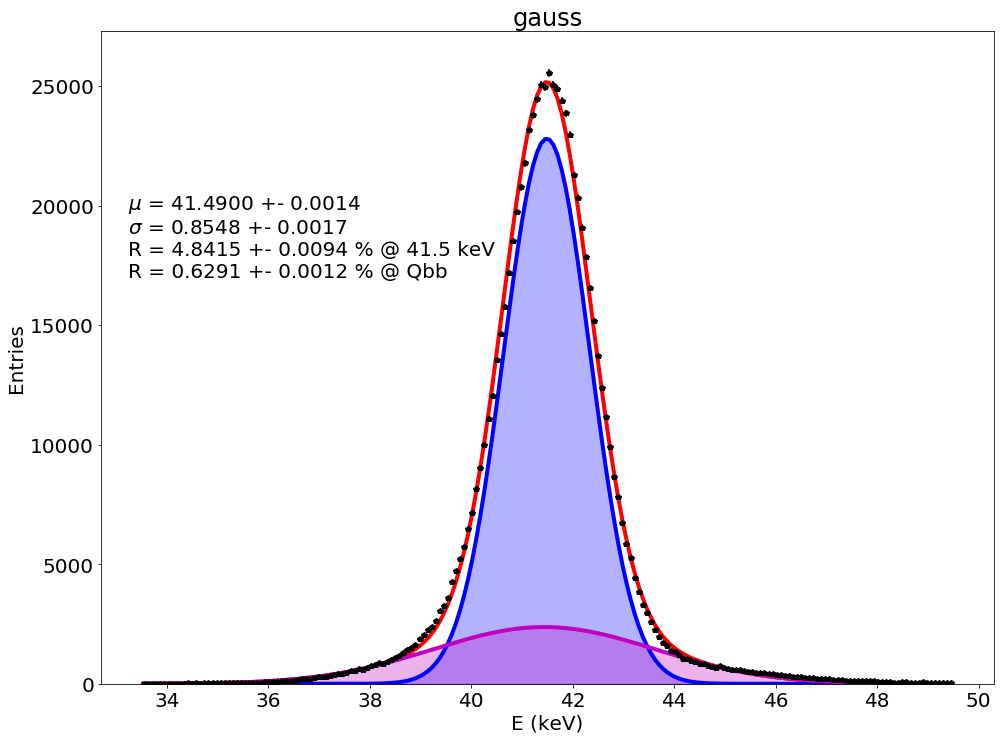

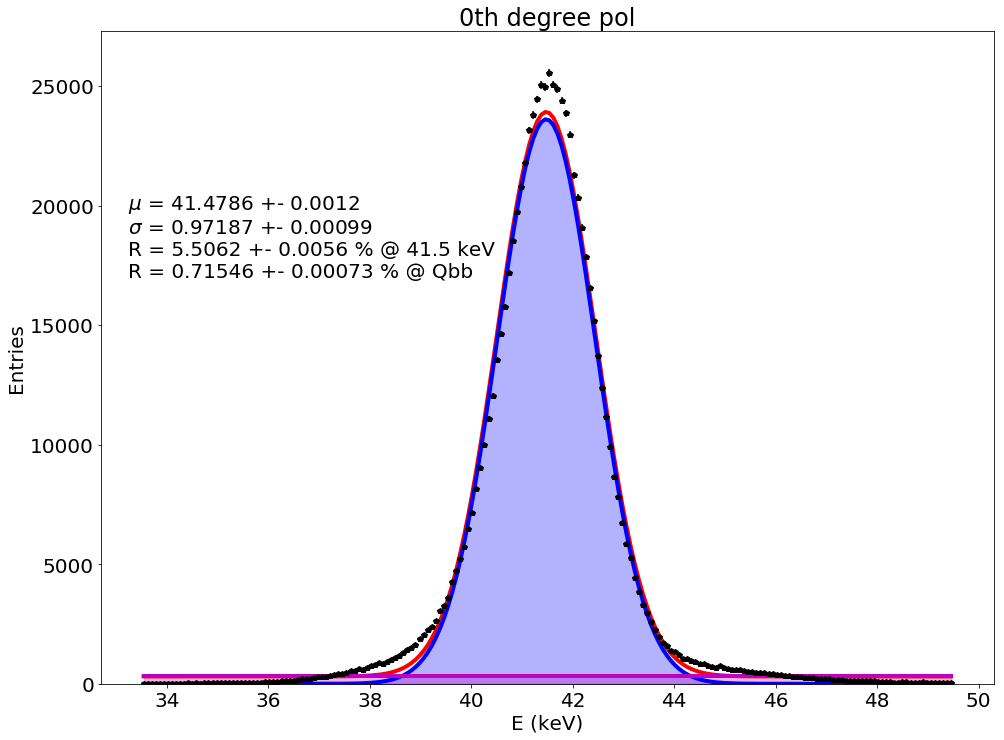

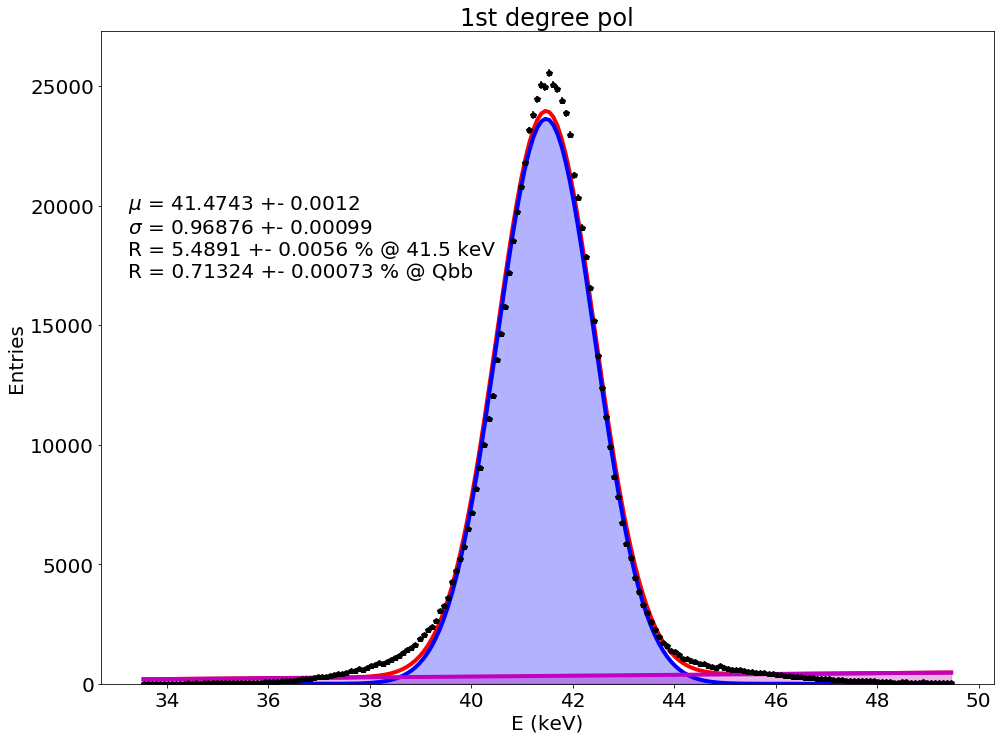

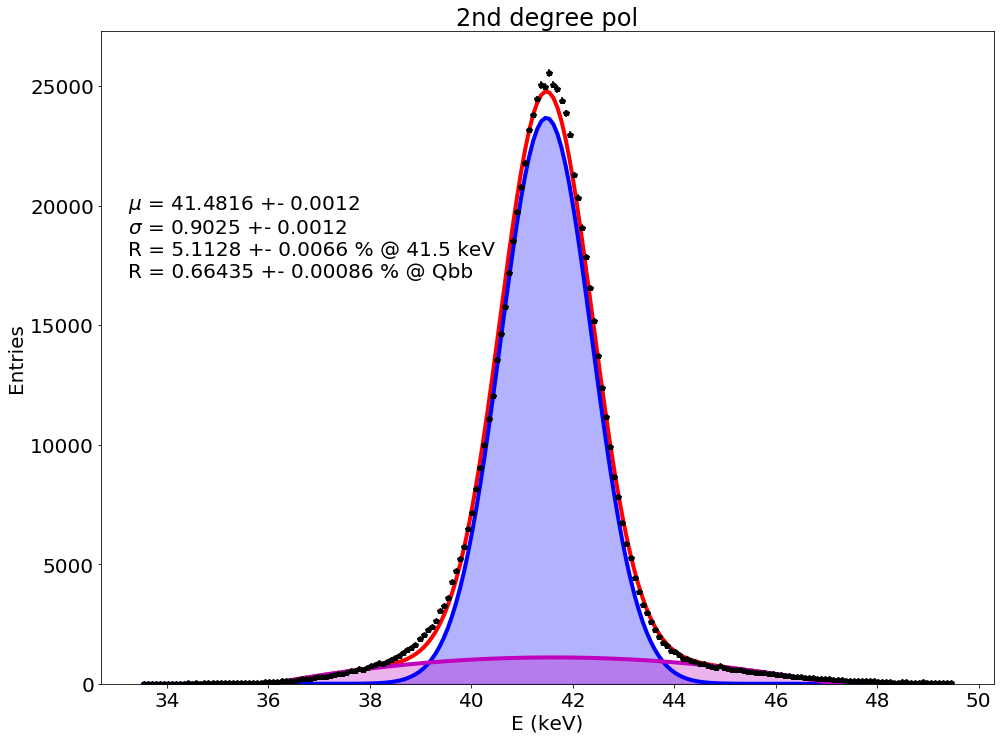

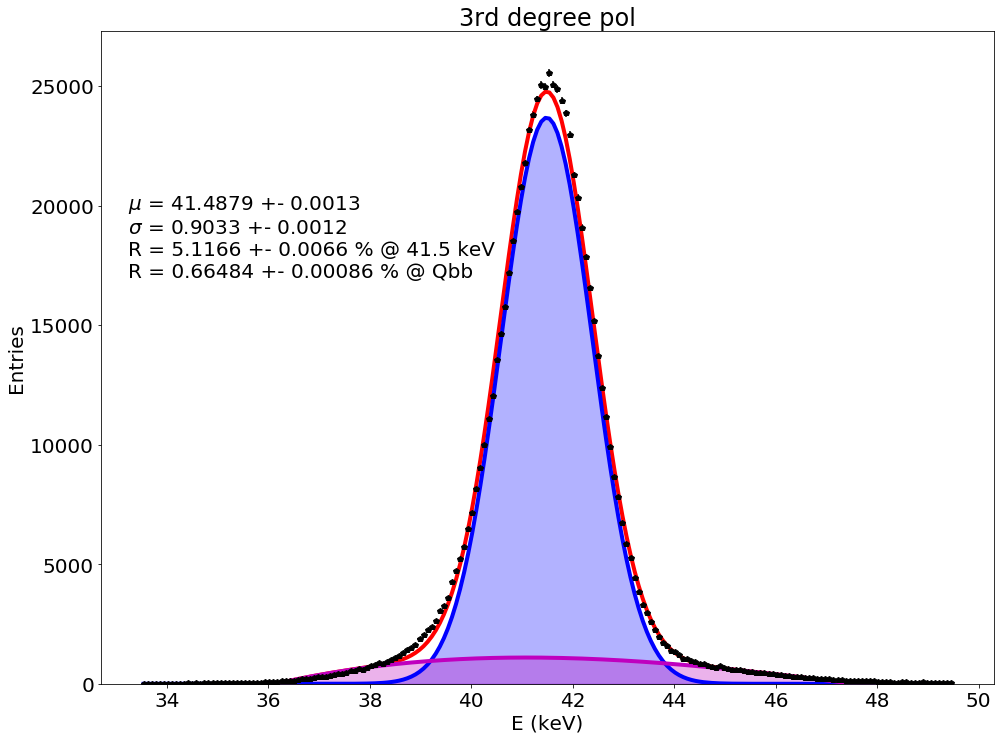

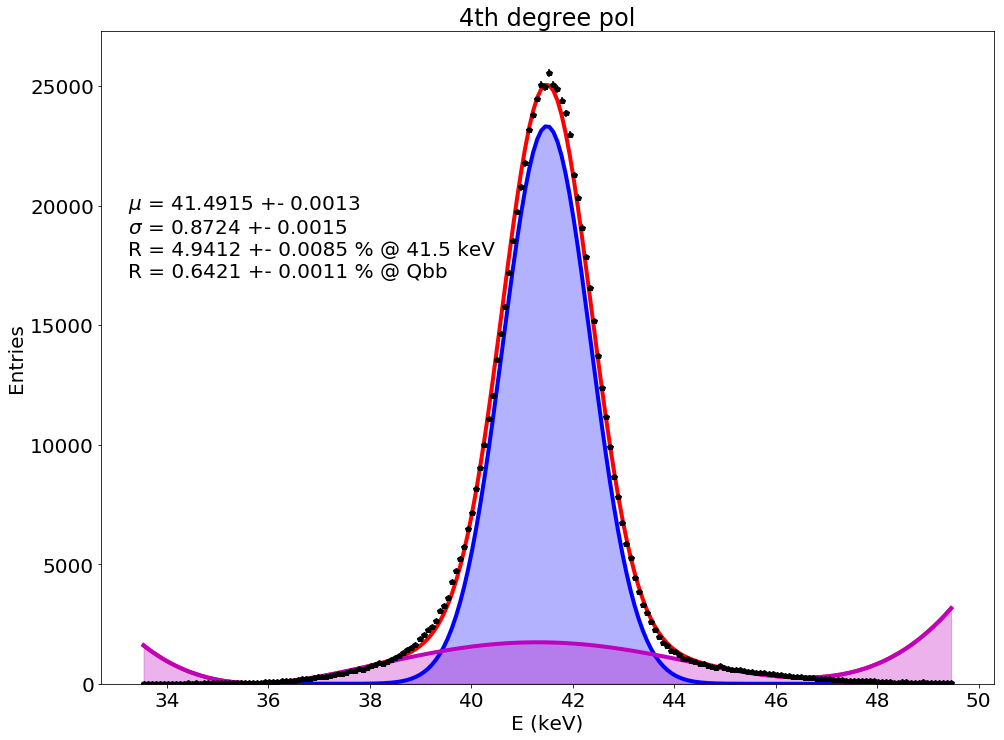

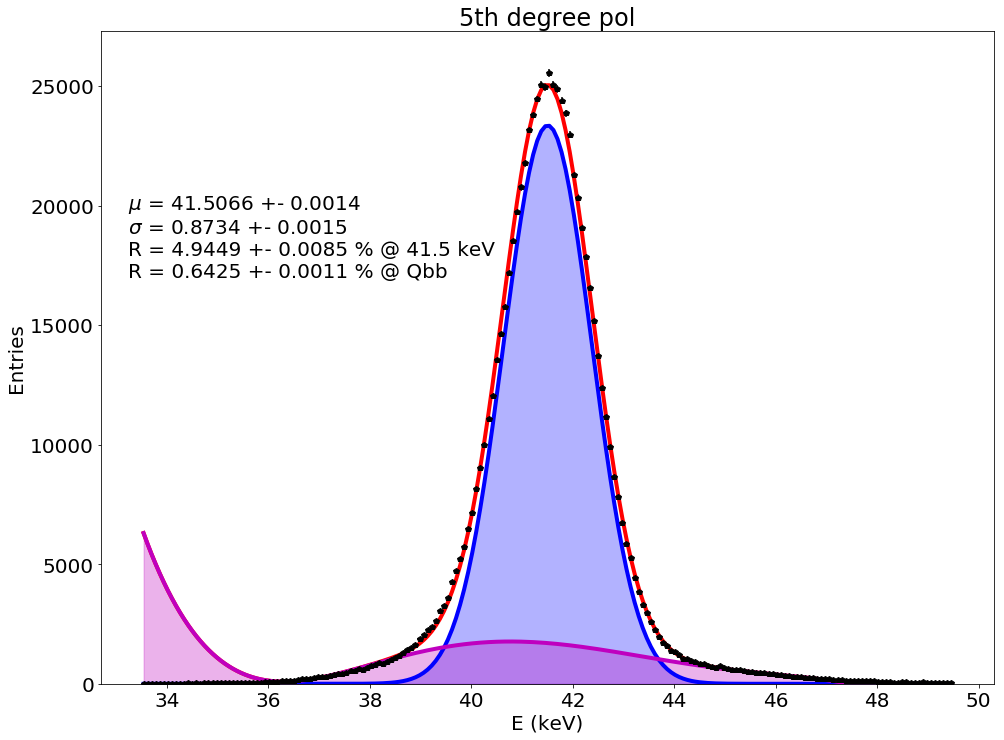

In [44]:
models   = {"gauss"         : dict(bkg = fitf.gauss            ),
            "0th degree pol": dict(bkg = fitf.polynom, degree=0),
            "1st degree pol": dict(bkg = fitf.polynom, degree=1),
            "2nd degree pol": dict(bkg = fitf.polynom, degree=2),
            "3rd degree pol": dict(bkg = fitf.polynom, degree=3),
            "4th degree pol": dict(bkg = fitf.polynom, degree=4),
            "5th degree pol": dict(bkg = fitf.polynom, degree=5)}
R_model  = {}
Ru_model = {}
chi_model = {}
for name, model in models.items():
    data = measure_resolution(E, n_sigma=4.2, **model)
    R_model[name], Ru_model[name] = data.R[0]
    chi_model[name] = data.f.chi2
    plt.figure()
    plot(data, bkg=model["bkg"], title=name)
    plt.ylim(*true_ylim)

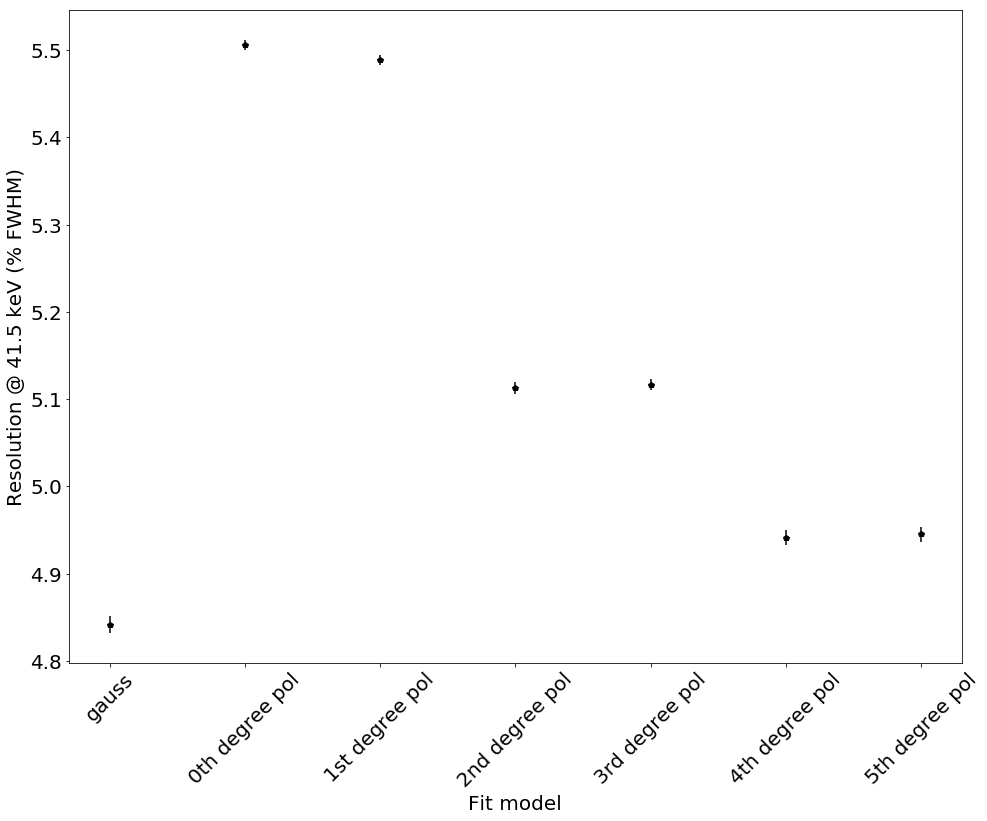

In [48]:
labels_, r, ru, chi2 = zip(*((m, R_model[m], Ru_model[m], chi_model[m]) for m in models))
xticks = np.arange(len(labels_))
plt.errorbar(xticks, r, ru, fmt="pk")
plt.gca().set_xticks     (xticks )
plt.gca().set_xticklabels(labels_)
plt.xticks(rotation=45)
labels("Fit model", "Resolution @ 41.5 keV (% FWHM)")

with open("/Users/Gonzalo/github/tese/dat/model_sys_4841_full.dat", "w") as file:
    file.write("model chi2 eres eresu\n")
    for m, chi, ir, iru in zip(labels_, chi2, r, ru):
        m = m.replace(" ", "_")
        file.write(f"{m} {chi} {ir} {iru}\n")

In [ ]:
R_model["2nd degree pol"] - R_model["5th degree pol"], R_model["2nd degree pol"] - R_model["4th degree pol"]